In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Dataset
import pandas as pd
train_df = pd.read_csv('data/train.csv',header=0)
test_df = pd.read_csv('data/test.csv',header=0)

In [3]:
# Fill null data with blank
train_df = train_df.fillna(' ')
test_df = test_df.fillna(' ')

In [4]:
# Combine all columns into a new one
train_df['all_info'] = train_df['text'] + train_df['title'] + train_df['author']
test_df['all_info'] = test_df['text'] + test_df['title'] + test_df['author']

In [5]:
# Defining target variable
target = train_df['label'].values

In [6]:
# Word Tokenization
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer

In [7]:
# Replace out of vocabulary token using oov_token=<OOV>
# Creates a vocabulary index based on word frequency
tokenizer = Tokenizer(oov_token = "<OOV>", num_words=6000)

In [8]:
# Fit the tokenizer on the texts and convert them into
# sequences of integers which uses the vocabulary index
# created by fitting the tokenizer
tokenizer.fit_on_texts(train_df['all_info'])

In [9]:
# The sequences could be of different lengths,
# pad_sequences is used to pad them with zeros at the end using padding=post
# now each sequence will have a length of 40
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 40
vocab_size = 6000

sequences_train = tokenizer.texts_to_sequences(train_df['all_info'])
sequences_test = tokenizer.texts_to_sequences(test_df['all_info'])

padded_train = pad_sequences(sequences_train, padding = 'post', maxlen=max_length)
padded_test = pad_sequences(sequences_test, padding = 'post', maxlen=max_length)

In [10]:
# Split into training and testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_train, target, test_size=0.2)
print(X_train.shape, " ", y_train.shape)

(16640, 40)   (16640,)


In [11]:
# Loading GloVe Dataset
# https://nlp.stanford.edu/projects/glove/
import numpy as np
embeddings_index = dict()
f = open('data/glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded {} word vectors.'.format(len(embeddings_index)))

Loaded 400000 word vectors.


In [12]:
# create a weight matrix for words in training docs
print('Get vocab_size')
vocab_size = len(tokenizer.word_index) + 1

print('Create the embedding matrix')
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Get vocab_size
Create the embedding matrix


In [13]:
# Classification Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
def get_simple_GloVe_model():
    model = Sequential()
    model.add(Embedding(vocab_size,
                        300,
                        weights=[embedding_matrix],
                        input_length=max_length,
                        trainable=False))
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

model = get_simple_GloVe_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           76332600  
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [14]:
# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [15]:
# Store best model in file
# Stop if last 15 epochs show no improvement
best_model_file_name = "models/best_model_LSTM_with_GloVe.hdf5"
callbacks=[
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=15,
                                  verbose=1,
                                  mode="min",
                                  restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath=best_model_file_name,
                                    verbose=1,
                                    save_best_only=True)
]

In [16]:
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

Epoch 1/50
520/520 [==============================] - ETA: 0s - loss: 0.2027 - precision: 0.8960 - recall: 0.9586
Epoch 1: val_loss improved from inf to 0.12984, saving model to models\best_model_LSTM_with_GloVe.hdf5
520/520 [==============================] - 20s 34ms/step - loss: 0.2027 - precision: 0.8960 - recall: 0.9586 - val_loss: 0.1298 - val_precision: 0.9179 - val_recall: 0.9830
Epoch 2/50
520/520 [==============================] - ETA: 0s - loss: 0.1094 - precision: 0.9478 - recall: 0.9739
Epoch 2: val_loss improved from 0.12984 to 0.10556, saving model to models\best_model_LSTM_with_GloVe.hdf5
520/520 [==============================] - 18s 34ms/step - loss: 0.1094 - precision: 0.9478 - recall: 0.9739 - val_loss: 0.1056 - val_precision: 0.9527 - val_recall: 0.9694
Epoch 3/50
519/520 [============================>.] - ETA: 0s - loss: 0.0840 - precision: 0.9617 - recall: 0.9783
Epoch 3: val_loss improved from 0.10556 to 0.08973, saving model to models\best_model_LSTM_with_GloVe.

In [17]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = [10,10]

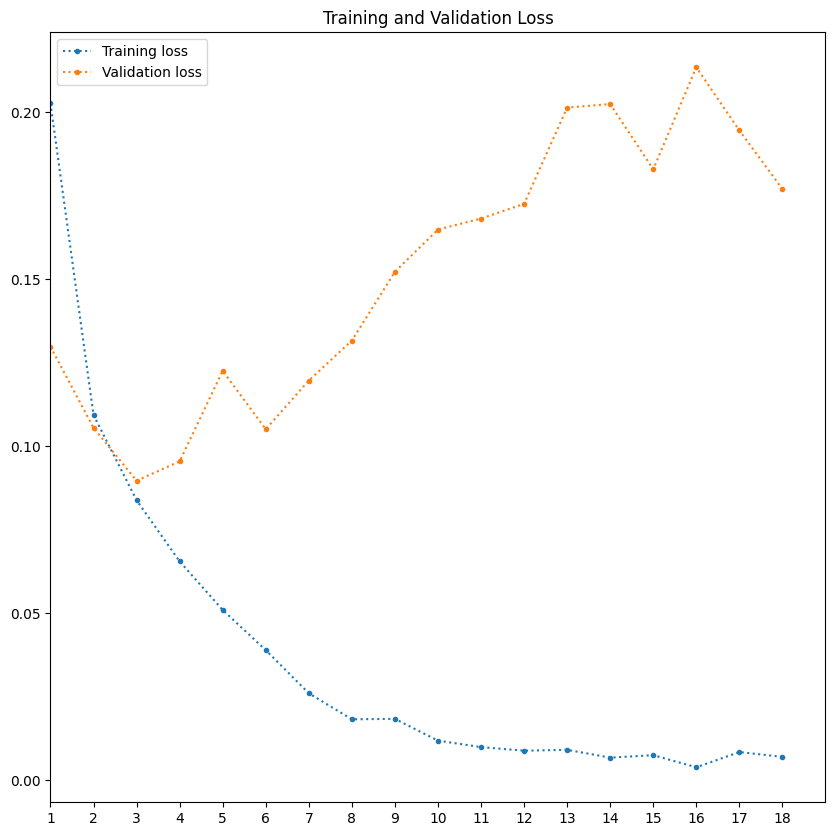

In [18]:
# Plot Loss

metric_to_plot = "loss"
plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training loss")
plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Loss')
plt.xlim([1,max(history.epoch) + 2])
plt.xticks(range(1, max(history.epoch) + 2))
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model = keras.models.load_model(best_model_file_name)
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

130/130 [==============================] - 2s 12ms/step
Accuracy:  0.9658653846153846
Precision:  0.9632495164410058
Recall:  0.967930029154519
F1 Score:  0.9655841008240427


In [20]:
# Create model file
import joblib
joblib.dump(model, 'fake_news_model_pipe.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\embedding
......vars
.........0
...layers\flatten
......vars
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...metrics\precision
......vars
.........0
.........1
...metrics\recall
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-03-20 20:21:22         3928
metadata.json                                  2023-03-20 20:21:22   

['fake_news_model_pipe.pkl']

# Process text to predict label

In [35]:
sample_data = """ Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed â€œno debate so far as I could ascertain as to who their spokesman was to beâ€ (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). â€œI am very glad that Miss Adams made it clear that what I am speaking for today is all of us â€”  the 400 of us,â€ Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie McCarthys and Mortimer Snerds in attendance, the    bespectacled in granny glasses (awarding her matronly wisdom â€”  or at least John Lennon wisdom) took issue with the previous speaker. Despite becoming the first   to win election to a seat in the U. S. Senate since Reconstruction, Edward Brooke came in for criticism for calling for â€œempathyâ€ for the goals of protestors as he criticized tactics. Though Clinton in her senior thesis on Saul Alinsky lamented â€œBlack Power demagoguesâ€ and â€œelitist arrogance and repressive intoleranceâ€ within the New Left, similar words coming out of a Republican necessitated a brief rebuttal. â€œTrust,â€ Rodham ironically observed in 1969, â€œthis is one word that when I asked the class at our rehearsal what it was they wanted me to say for them, everyone came up to me and said â€˜Talk about trust, talk about the lack of trust both for us and the way we feel about others. Talk about the trust bust.â€™ What can you say about it? What can you say about a feeling that permeates a generation and that perhaps is not even understood by those who are distrusted?â€ The â€œtrust bustâ€ certainly busted Clintonâ€™s 2016 plans. She certainly did not even understand that people distrusted her. After Whitewater, Travelgate, the vast   conspiracy, Benghazi, and the missing emails, Clinton found herself the distrusted voice on Friday. There was a load of compromising on the road to the broadening of her political horizons. And distrust from the American people â€”  Trump edged her 48 percent to 38 percent on the question immediately prior to Novemberâ€™s election â€”  stood as a major reason for the closing of those horizons. Clinton described her vanquisher and his supporters as embracing a â€œlie,â€ a â€œcon,â€ â€œalternative facts,â€ and â€œa   assault on truth and reason. â€ She failed to explain why the American people chose his lies over her truth. â€œAs the history majors among you here today know all too well, when people in power invent their own facts and attack those who question them, it can mark the beginning of the end of a free society,â€ she offered. â€œThat is not hyperbole. â€ Like so many people to emerge from the 1960s, Hillary Clinton embarked upon a long, strange trip. From high school Goldwater Girl and Wellesley College Republican president to Democratic politician, Clinton drank in the times and the place that gave her a degree. More significantly, she went from idealist to cynic, as a comparison of her two Wellesley commencement addresses show. Way back when, she lamented that â€œfor too long our leaders have viewed politics as the art of the possible, and the challenge now is to practice politics as the art of making what appears to be impossible possible. â€ Now, as the big woman on campus but the odd woman out of the White House, she wonders how her current station is even possible. â€œWhy arenâ€™t I 50 points ahead?â€ she asked in September. In May she asks why she isnâ€™t president. The woman famously dubbed a â€œcongenital liarâ€ by Bill Safire concludes that lies did her in â€”  theirs, mind you, not hers. Getting stood up on Election Day, like finding yourself the jilted bride on your wedding day, inspires dangerous delusions."""

In [36]:
# Text Cleaning
import re
from string import punctuation
# Remove extra spaces, tabs, and line breaks
sample_data = " ".join(sample_data.split())
# Remove punctuation
sample_data = re.sub(f"[{re.escape(punctuation)}]", "", sample_data)
# Remove numbers
sample_data = re.sub(r"\b[0-9]+\b\s*", "", sample_data)
# Remove non-alphabetic characters and extra spaces
sample_data = " ".join([w for w in sample_data.split() if w.isalpha()])

In [37]:
# Expand contractions and then convert to lower-case.
import contractions
word_list = []
for each_word in sample_data.split(' '):
    try:
        word_list.append(contractions.fix(each_word).lower())
    except:
        print("Error in contractions")
sample_data = " ".join(word_list)

In [38]:
import pandas as pd
sample_df = pd.DataFrame([sample_data], columns=['all_info'])

In [39]:
# Word Tokenization
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer

In [40]:
# Replace out of vocabulary token using oov_token=<OOV>
# Creates a vocabulary index based on word frequency
tokenizer = Tokenizer(oov_token = "<OOV>", num_words=6000)

In [41]:
# Fit the tokenizer on the texts and convert them into
# sequences of integers which uses the vocabulary index
# created by fitting the tokenizer
tokenizer.fit_on_texts(sample_df['all_info'])

In [42]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 40
vocab_size = 6000

sequences_sample = tokenizer.texts_to_sequences(sample_df['all_info'])
padded_sample = pad_sequences(sequences_sample, padding = 'post', maxlen=max_length)

In [45]:
import joblib
fake_news_model = joblib.load('fake_news_model_pipe.pkl')
prediction = (fake_news_model.predict(padded_sample)> 0.5).astype("int32")

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-20 20:21:22         3928
metadata.json                                  2023-03-20 20:21:22           64
variables.h5                                   2023-03-20 20:21:22    307369920
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\embedding
......vars
.........0
...layers\flatten
......vars
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...metrics\precision
......vars
.........0
.........1
...metrics\recall
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
....

In [46]:
print(prediction)

[[1]]
